# Ermanno Girardo,Alessio Roda, Enzo Ubaldo Petrocco
# This is the ML project for the exam
## **Prediction of Tweets**


### **Import all the libraries:**


In [1]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False 

import numpy as np
import pandas as pd
!pip install text_hammer
import text_hammer as th
import seaborn as sns
import matplotlib.pyplot as plt
import re
from wordcloud import STOPWORDS
from collections import defaultdict
#%%time
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
!pip install transformers
from transformers import AutoTokenizer,TFBertModel

max_len = 36

import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense

from nltk.corpus import stopwords
from wordcloud import WordCloud

     |████████████████████████████████| 115 kB 5.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 3.5 MB 4.9 MB/s 
     |████████████████████████████████| 596 kB 55.8 MB/s 
     |████████████████████████████████| 895 kB 50.0 MB/s 
     |████████████████████████████████| 67 kB 4.4 MB/s 
     |████████████████████████████████| 6.8 MB 32.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### **LOADING DATABASE:**

In [2]:
train_data = pd.read_csv('NLP_Natural_Disaster_Tweets/train.csv',usecols=['id','text','target'])
test_data = pd.read_csv('NLP_Natural_Disaster_Tweets/test.csv',usecols=['id','text'])
sample_data = pd.read_csv('NLP_Natural_Disaster_Tweets/submission.csv')

### **Show the output:**

In [3]:
test_data.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [4]:
train_data.head()


,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


### **Show the shape of vectors:**

In [5]:
train_data.shape

(7613, 3)

### **Preprocessing of the data:** Function to remove all the useless information to the rows

In [6]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
#     df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
#     df[column] = df[column].progress_apply(lambda x: ps.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
#     df[column] = df[column].progress_apply(lambda x: th.make_base(x)) #ran -> run,
    return(df)

### **Apply it to training data:**

In [7]:
train_cleaned_data = text_preprocessing(train_data,'text')

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

  0%|          | 0/7613 [00:00<?, ?it/s]

### **We can query all the rows with target 0:** They are all the no disaster tweets

Target could be or 1 or 0 (binary classification):

* 1 Means a natural disaster / accident tweet
* 0 It is an useless tweet

In [8]:
train_cleaned_data[train_cleaned_data.target == 0]

,id,text,target
15,23,whats up man,0
16,24,i love fruits,0
17,25,summer is lovely,0
18,26,my car is so fast,0
19,28,what a goooooooaaaaaal,0
...,...,...,...
7581,10833,engineshed great atmosphere at the british lio...,0
7582,10834,cramer igers 3 words that wrecked disneys stoc...,0
7584,10837,these boxes are ready to explode exploding kit...,0
7587,10841,sirens everywhere,0


### **Make a copy of the trained cleaned:**

In [9]:

train_data = train_cleaned_data.copy()


### **See the head of the training dataframe:**

In [10]:
train_data.head(10)

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask canada,1
2,5,all residents asked to shelter in place are be...,1
3,6,13000 people receive wildfires evacuation orde...,1
4,7,just got sent this photo from ruby alaska as s...,1
5,8,rockyfire update california hwy 20 closed in b...,1
6,10,flood disaster heavy rain causes flash floodin...,1
7,13,im on top of the hill and i can see a fire in ...,1
8,14,theres an emergency evacuation happening now i...,1
9,15,im afraid that the tornado is coming to our area,1


### **Include Natural Language Tool KIT ( NLTK):**

In [11]:
  import nltk
  nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### **WORD CLOUD:** In particular replace ' ' for the stop words.

In [12]:
stop_words = set(stopwords.words('english'))
train_data['text'] = train_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

### **Estrapolate all the disaster words:**

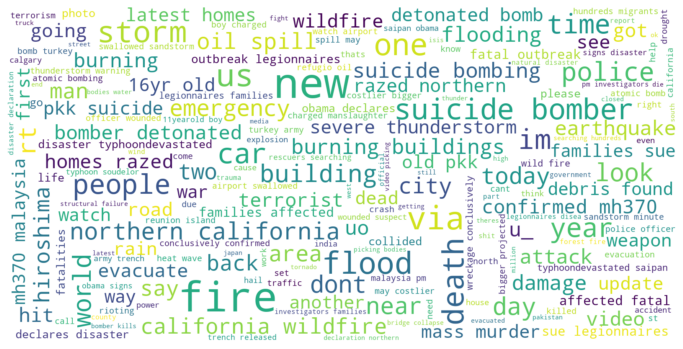

In [13]:
#Disaster Tweets wordcloud 
disaster_tweets = train_data[train_data.target == 1]
disaster_string = []
for t in disaster_tweets.text:
    disaster_string.append(t)
disaster_string = pd.Series(disaster_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(disaster_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### **Positive word cloud:**

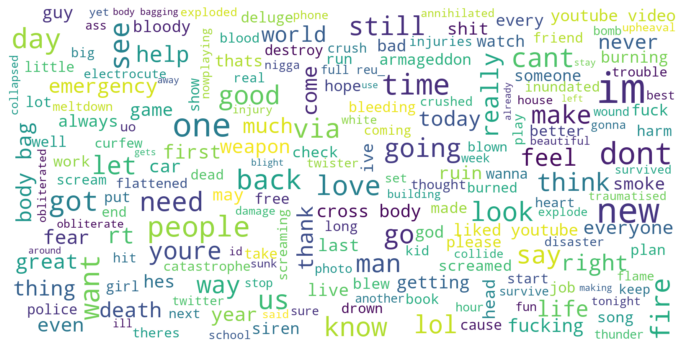

In [14]:
# Positive tweets wordcloud
formal_tweets = train_data[train_data.target == 0]
formal_string = []
for t in formal_tweets.text:
    formal_string.append(t)
formal_string = pd.Series(formal_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=100, background_color='white').generate(formal_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### ***Data Visualization:***

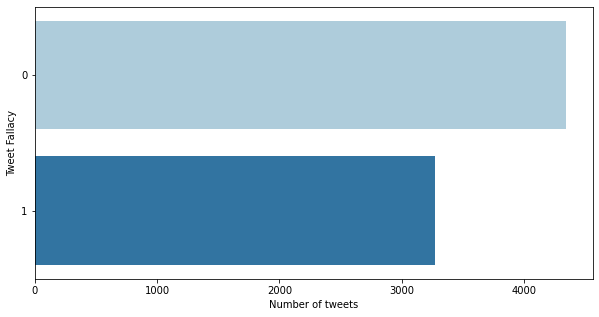

In [15]:
#Visualizing class distribution
#Seaborn: tool for statistical data visualization 
plt.figure(figsize=(10,5))
sns.countplot(y='target',data = train_data,palette="Paired")
plt.ylabel("Tweet Fallacy")
plt.xlabel("Number of tweets")
plt.show()

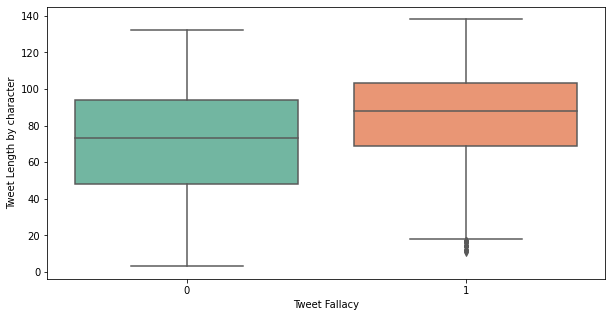

In [16]:
#Visualizing tweet length by characaters
plt.figure(figsize=(10,5))
train_sent = train_data['text'].str.len()
sns.boxplot(x="target",y=train_sent,data=train_data,palette="Set2")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet Length by character")
plt.show()

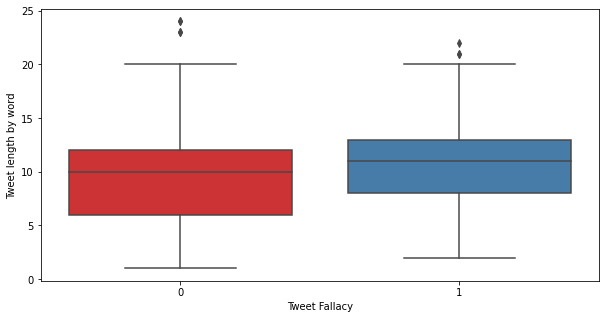

In [17]:
#Visualizing tweet length by words
plt.figure(figsize=(10,5))
train_sent = train_data['text'].str.split().map(lambda x : len(x))
sns.boxplot(x="target",y=train_sent,data=train_data,palette="Set1")
plt.xlabel("Tweet Fallacy")
plt.ylabel("Tweet length by word")
plt.show()

### ***Manipulate the dataframe:***

*   Split the text string in a vector of 'token' (useful words)
*   Count the words for each row
*   Count the words without repetitions
*   Count the stop word / url 
*   Compute the mean word length ( in terms of characters)
*   Compute the total number of characters



In [18]:
# word_count
train_data['word_count'] = train_data['text'].apply(lambda x: len(str(x).split()))
test_data['word_count'] = test_data['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_data['unique_word_count'] = train_data['text'].apply(lambda x: len(set(str(x).split())))
test_data['unique_word_count'] = test_data['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_data['stop_word_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_data['stop_word_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_data['url_count'] = train_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_data['url_count'] = test_data['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_data['mean_word_length'] = train_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_data['mean_word_length'] = test_data['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_data['char_count'] = train_data['text'].apply(lambda x: len(str(x)))
test_data['char_count'] = test_data['text'].apply(lambda x: len(str(x)))

### ***Extrapolate some useful plots:***
On the left you can see the difference between disaster/non disaster tweets, on the right you can see the difference between training and test set.

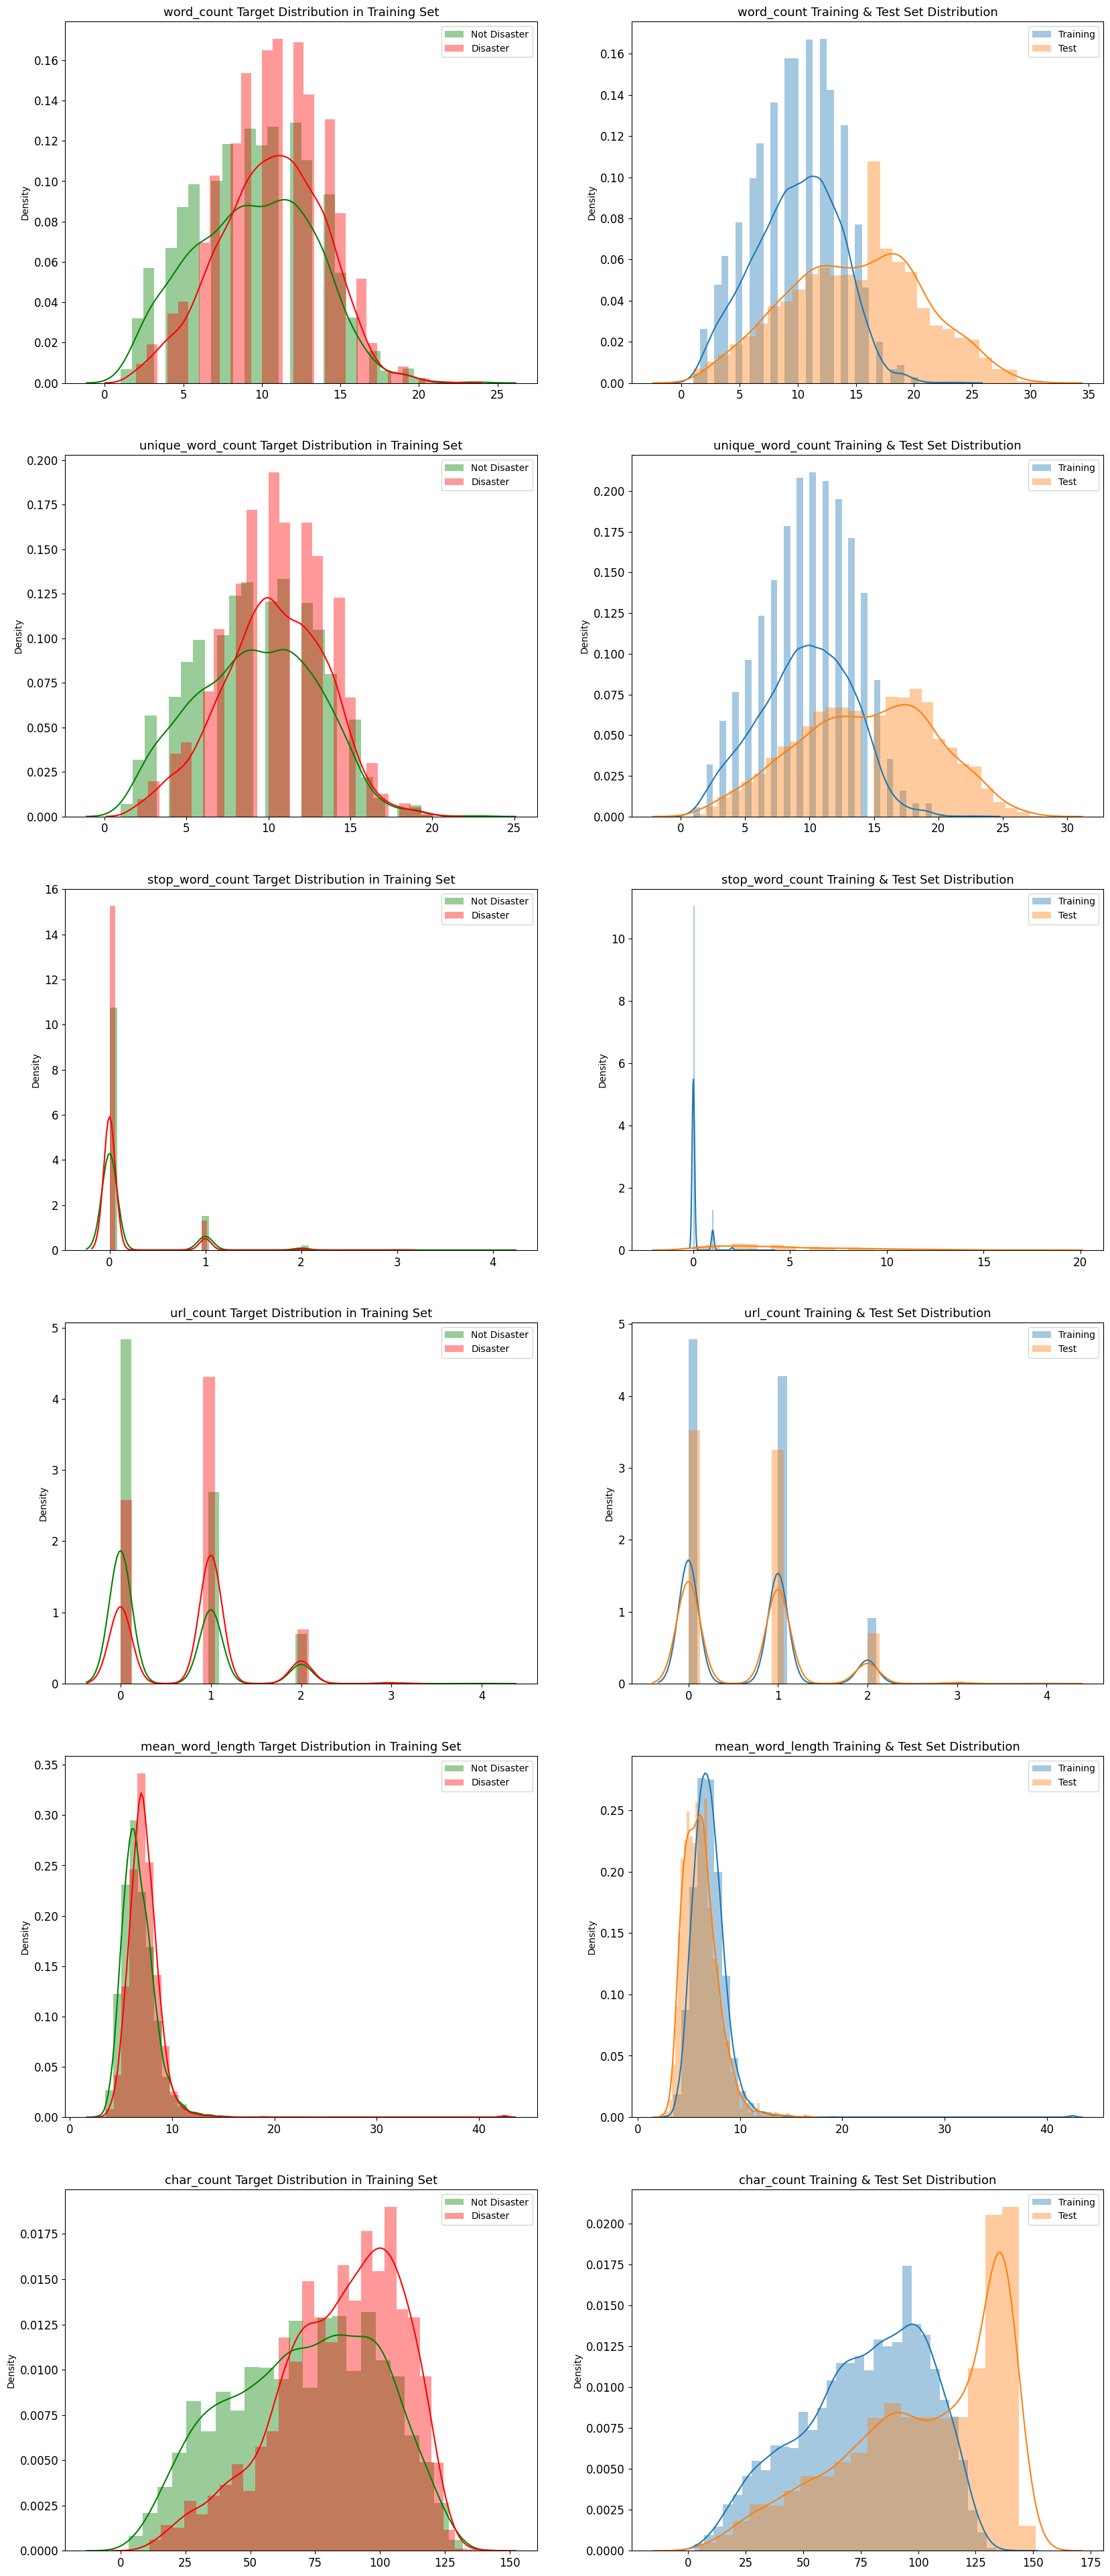

In [19]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count']
DISASTER_TWEETS = train_data['target'] == 1
#Instanciate the subplots with matplot library
fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

#Build the plots for each metafutures
for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_data.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_data.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')
    sns.distplot(train_data[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_data[feature], label='Test', ax=axes[i][1])
    # build the legened and tick parameters
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    #for each subplot print the title
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)
plt.show()


### ***Pie plot of the number of disaster tweets respect to no disasters one***

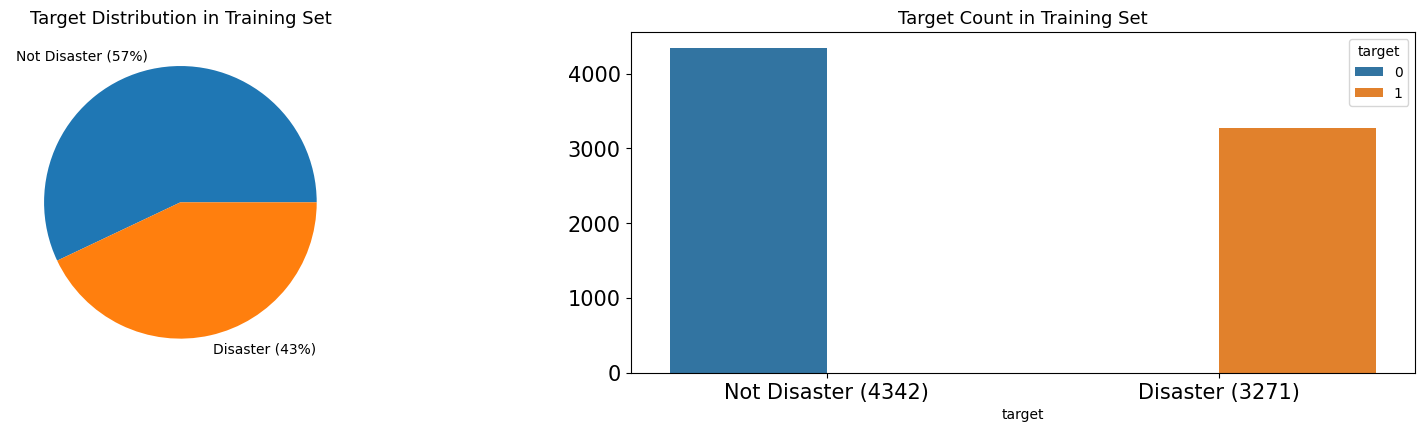

In [20]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

train_data.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=train_data['target'], hue=train_data['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

### ***BERT Model:*** BERT stays for Bidirectional Encoder Representations from Transformers  is a transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google.

## ***Import the BERT model***

In [21]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [22]:
tokenizer('Happy deep learning project')

{'input_ids': [101, 3407, 2784, 4083, 2622, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

### ***Convert dataframe in usefull input for BERT input format:***

In [23]:
print("max len of tweets",max([len(x.split()) for x in train_data.text]))
max_length = 36

max len of tweets 24


### ***Build the train data text into BERT format, specifying all the parameters:***

In [24]:
x_train = tokenizer(
    text=train_data.text.tolist(),
    add_special_tokens=True,
    max_length=36,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [25]:
x_train['input_ids'].shape

TensorShape([7613, 36])

In [26]:
x_train['attention_mask'].shape

TensorShape([7613, 36])

### ***Take the output of the train array:***

In [27]:
y_train = train_data.target.values
(y_train)

array([1, 1, 1, ..., 1, 1, 1])

In [28]:
train_data.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

### ***Build the model architecture:***

In [29]:
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[1] #0 is last hidden layer, 1 is the pooler output
out = tf.keras.layers.Dropout(0.1)(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True 


### ***Display the overall model:***

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 36)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 36)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 36,                                            

###***Choose the optimizer:***

In [31]:
#Adam optimization is a stochastic gradient descent method that is based 
#on adaptive estimation of first-order and second-order moments.
optimizer = Adam(
    learning_rate=6e-06, # this learning rate is for bert model.
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

### ***Set loss and metrics:***

In [33]:
# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True) # It's used since we use a binary classifier, 
                                             #Computes the cross-entropy loss between true labels and predicted labels.
metric = BinaryAccuracy('accuracy') #Dice quanto spesso y predetto = y true, calcola la frequenza con la quale la 
                                    # y pred coincide con y true
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

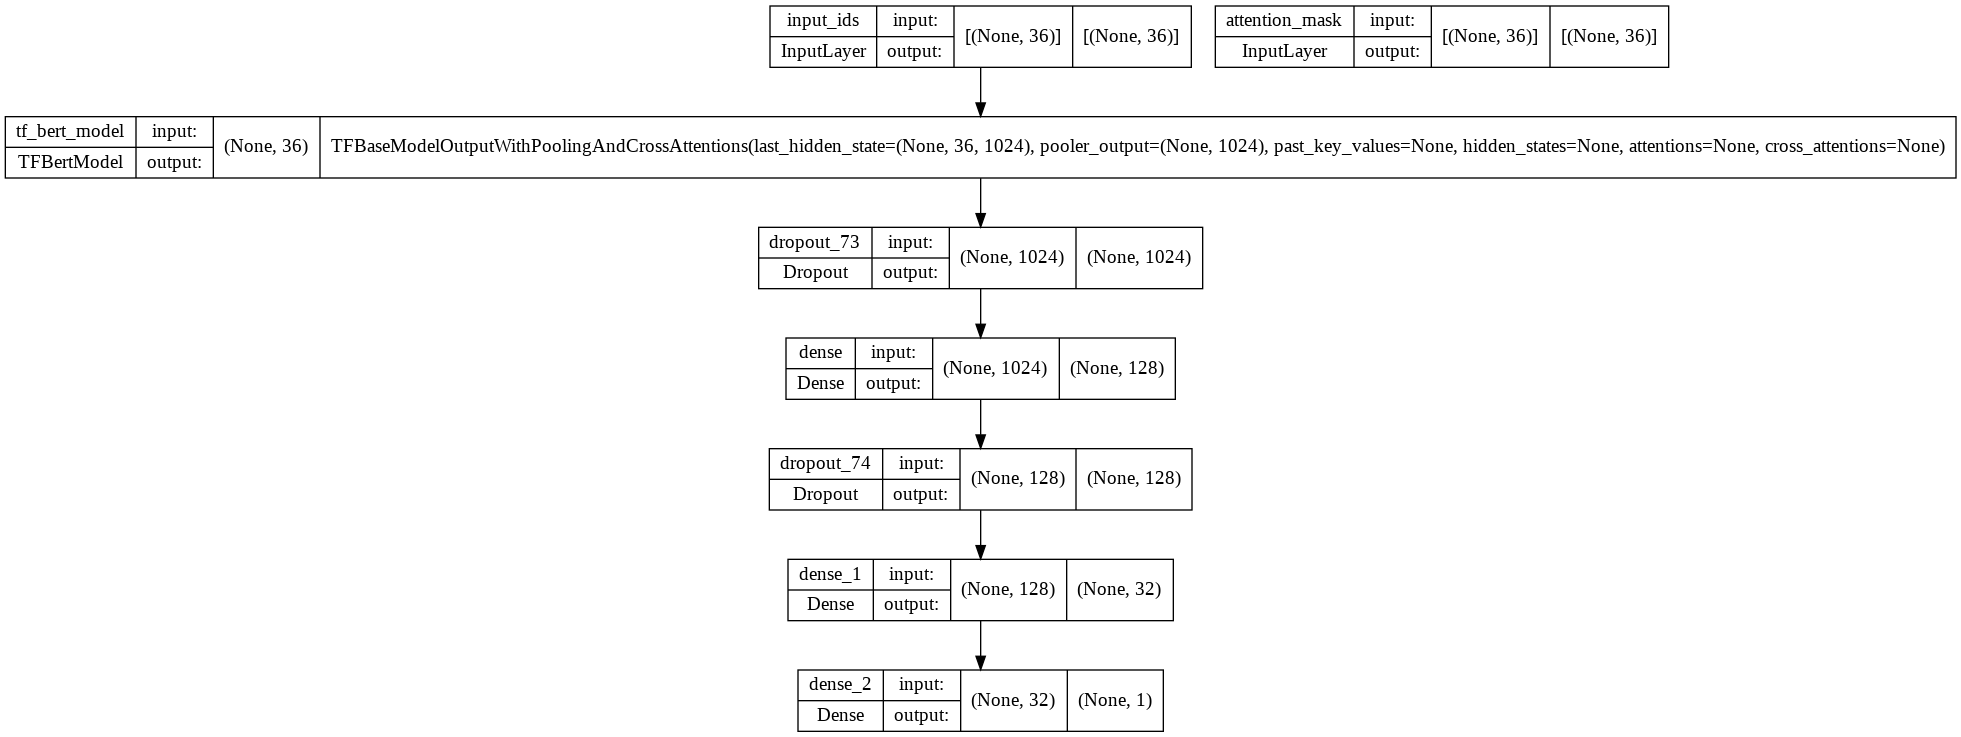

In [34]:
plot_model(model, show_shapes = True)

In [ ]:
# Fit the model, Trains the model for a fixed number of epochs (iterations on a dataset).
final = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
#   validation_split = 0.1,
  epochs=9, #iterations on a dataset
    batch_size=10
)

Epoch 1/9
762/762 [==============================] - 12172s 16s/step - loss: 0.5151 - accuracy: 0.7622
Epoch 2/9
504/762 [==================>...........] - ETA: 1:08:10 - loss: 0.4274 - accuracy: 0.8321